In [1]:
import sys, os, importlib, numpy as np, pandas as pd
sys.path.append(os.path.abspath(".."))

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from src import data as data_mod, features as features_mod, utils as utils_mod
importlib.reload(data_mod); importlib.reload(features_mod); importlib.reload(utils_mod)
from src.data import get_data
from src.features import add_features
from src.utils import make_labels

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False


In [2]:
TICKER = "AAPL"                 # try: "SPY", "MSFT", "BTC-USD"
START, END = "2015-01-01", "2023-12-31"
DEAD_ZONE, TAU = True, 0.001    # ±0.1% dead-zone
FEE = 0.0010                    # 10 bps one-way
MODELS = ["logreg", "xgb"]      # run both baselines
FOLDS = 5                       # number of rolling folds


In [3]:
df = get_data(TICKER, start=START, end=END)
df = add_features(df)
df = make_labels(df, tau=TAU, dead_zone=DEAD_ZONE)

feat_cols = [c for c in df.columns if c not in ["date","open","high","low","close","volume","ret_next","y"]]
X_all = df[feat_cols].values
y_all = df["y"].astype(int).values
r_all = df["ret_next"].values
dates_all = df["date"].values
len(df), len(feat_cols)


(2078, 8)

In [4]:
def time_folds(n, k=5, train_min=0.50, val_size=0.10, test_size=0.10):
    train_end0 = int(n*train_min)
    block = int(n*(val_size+test_size)/max(k,1))
    for i in range(k):
        tr_end = train_end0 + i*block
        va_end = tr_end + int(n*val_size)
        te_end = va_end + int(n*test_size)
        if te_end > n: break
        yield slice(0, tr_end), slice(tr_end, va_end), slice(va_end, te_end)

def sharpe_daily(r):
    r = pd.Series(r); s = r.std()
    return 0.0 if s==0 else r.mean()/s*np.sqrt(252)

def strat_sharpe_from_probs(p, ret_next, fee=FEE, thr=0.55):
    pos = (p > thr).astype(int)
    trades = np.abs(np.diff(np.r_[0, pos])) * fee
    strat_r = pos * ret_next - trades
    return sharpe_daily(strat_r)

def tune_threshold_on_val(p_val, ret_next_val, fee=FEE, grid=np.linspace(0.50,0.60,21)):
    scores = [(t, strat_sharpe_from_probs(p_val, ret_next_val, fee=fee, thr=t)) for t in grid]
    return max(scores, key=lambda x: x[1])[0]

def backtest_from_probs(p_test, ret_next_test, thr, fee=FEE):
    pos = (p_test > thr).astype(int)
    trades = np.abs(np.diff(np.r_[0, pos])) * fee
    strat_r = pos * ret_next_test - trades
    bh_r = ret_next_test
    def eq(returns): return (1+pd.Series(returns)).cumprod()
    def mdd(ec): peak = ec.cummax(); return (ec/peak - 1).min()
    eq_s, eq_b = eq(strat_r), eq(bh_r)
    return {
        "Sharpe_strat": sharpe_daily(strat_r),
        "Sharpe_bh": sharpe_daily(bh_r),
        "MaxDD_strat": mdd(eq_s),
        "MaxDD_bh": mdd(eq_b)
    }


In [5]:
results = []
n = len(df)

for tr, va, te in time_folds(n, k=FOLDS, train_min=0.50, val_size=0.10, test_size=0.10):
    X_tr, y_tr = X_all[tr], y_all[tr]
    X_va, y_va = X_all[va], y_all[va]
    X_te, y_te = X_all[te], y_all[te]
    r_va, r_te = r_all[va], r_all[te]

    scaler = StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr); X_va = scaler.transform(X_va); X_te = scaler.transform(X_te)

    fold = {
        "fold_train_end": str(dates_all[tr.stop-1]),
        "fold_test_end": str(dates_all[te.stop-1]),
    }

    if "logreg" in MODELS:
        lr = LogisticRegression(max_iter=2000, class_weight="balanced")
        lr.fit(X_tr, y_tr)
        p_va = lr.predict_proba(X_va)[:,1]
        p_te = lr.predict_proba(X_te)[:,1]
        thr = tune_threshold_on_val(p_va, r_va, fee=FEE)
        bt = backtest_from_probs(p_te, r_te, thr, fee=FEE)
        fold.update({
            "AUC_va_log": roc_auc_score(y_va, p_va),
            "AUC_te_log": roc_auc_score(y_te, p_te),
            "thr_log": float(thr),
            **{f"{k}_log": v for k,v in bt.items()}
        })

    if "xgb" in MODELS and HAS_XGB:
        xgb = XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            random_state=42, n_jobs=-1
        )
        xgb.fit(X_tr, y_tr)
        p_va_x = xgb.predict_proba(X_va)[:,1]
        p_te_x = xgb.predict_proba(X_te)[:,1]
        thr_x = tune_threshold_on_val(p_va_x, r_va, fee=FEE)
        bt_x = backtest_from_probs(p_te_x, r_te, thr_x, fee=FEE)
        fold.update({
            "AUC_va_xgb": roc_auc_score(y_va, p_va_x),
            "AUC_te_xgb": roc_auc_score(y_te, p_te_x),
            "thr_xgb": float(thr_x),
            **{f"{k}_xgb": v for k,v in bt_x.items()}
        })

    results.append(fold)

wf = pd.DataFrame(results)
wf


,fold_train_end,fold_test_end,AUC_va_log,AUC_te_log,thr_log,Sharpe_strat_log,Sharpe_bh_log,MaxDD_strat_log,MaxDD_bh_log,AUC_va_xgb,AUC_te_xgb,thr_xgb,Sharpe_strat_xgb,Sharpe_bh_xgb,MaxDD_strat_xgb,MaxDD_bh_xgb
0,2019-08-08T00:00:00.000000000,2021-05-07T00:00:00.000000000,0.557105,0.472634,0.530,0.097606,1.324020,-0.260440,-0.204283,0.470588,0.486785,0.570,0.587671,1.324020,-0.136157,-0.204283
1,2019-12-17T00:00:00.000000000,2021-09-13T00:00:00.000000000,0.537240,0.484381,0.545,0.629504,1.331578,-0.117085,-0.185988,0.513989,0.505705,0.525,0.652248,1.331578,-0.201006,-0.185988
2,2020-04-23T00:00:00.000000000,2022-01-21T00:00:00.000000000,0.511297,0.494822,0.545,1.428939,1.705210,-0.088362,-0.113006,0.502730,0.547543,0.590,1.360791,1.705210,-0.085640,-0.113006
3,2020-08-28T00:00:00.000000000,2022-05-24T00:00:00.000000000,0.486736,0.468149,0.550,-0.472866,0.029797,-0.110361,-0.242972,0.476649,0.532879,0.505,0.446827,0.029797,-0.135930,-0.242972
4,2021-01-07T00:00:00.000000000,2022-09-28T00:00:00.000000000,0.498968,0.446572,0.590,-1.841554,-0.174402,-0.051855,-0.282526,0.496528,0.568746,0.520,0.151888,-0.174402,-0.217309,-0.282526


,fold_train_end,fold_test_end,AUC_va_log,AUC_te_log,thr_log,Sharpe_strat_log,Sharpe_bh_log,MaxDD_strat_log,MaxDD_bh_log,AUC_va_xgb,AUC_te_xgb,thr_xgb,Sharpe_strat_xgb,Sharpe_bh_xgb,MaxDD_strat_xgb,MaxDD_bh_xgb
0,2019-08-08T00:00:00.000000000,2021-05-07T00:00:00.000000000,0.557105,0.472634,0.530,0.097606,1.324020,-0.260440,-0.204283,0.470588,0.486785,0.570,0.587671,1.324020,-0.136157,-0.204283
1,2019-12-17T00:00:00.000000000,2021-09-13T00:00:00.000000000,0.537240,0.484381,0.545,0.629504,1.331578,-0.117085,-0.185988,0.513989,0.505705,0.525,0.652248,1.331578,-0.201006,-0.185988
2,2020-04-23T00:00:00.000000000,2022-01-21T00:00:00.000000000,0.511297,0.494822,0.545,1.428939,1.705210,-0.088362,-0.113006,0.502730,0.547543,0.590,1.360791,1.705210,-0.085640,-0.113006
3,2020-08-28T00:00:00.000000000,2022-05-24T00:00:00.000000000,0.486736,0.468149,0.550,-0.472866,0.029797,-0.110361,-0.242972,0.476649,0.532879,0.505,0.446827,0.029797,-0.135930,-0.242972
4,2021-01-07T00:00:00.000000000,2022-09-28T00:00:00.000000000,0.498968,0.446572,0.590,-1.841554,-0.174402,-0.051855,-0.282526,0.496528,0.568746,0.520,0.151888,-0.174402,-0.217309,-0.282526



=== Averages across folds ===


,mean
AUC_va_log,0.5183
AUC_te_log,0.4733
Sharpe_strat_log,-0.0317
Sharpe_bh_log,0.8432
MaxDD_strat_log,-0.1256
MaxDD_bh_log,-0.2058
AUC_va_xgb,0.4921
AUC_te_xgb,0.5283
Sharpe_strat_xgb,0.6399
Sharpe_bh_xgb,0.8432


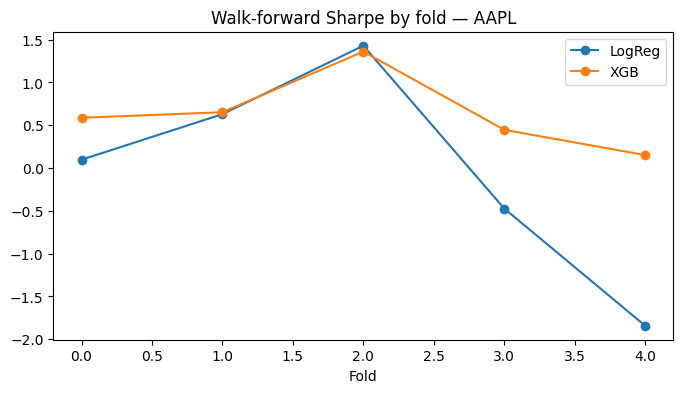

In [6]:
cols = [c for c in wf.columns if any(k in c for k in ["AUC_","Sharpe_","MaxDD_"])]
summary = wf[cols].mean().to_frame("mean").round(4)
display(wf)
print("\n=== Averages across folds ===")
display(summary)

plt.figure(figsize=(8,4))
if "Sharpe_strat_log" in wf: plt.plot(wf["Sharpe_strat_log"].values, marker="o", label="LogReg")
if "Sharpe_strat_xgb" in wf: plt.plot(wf["Sharpe_strat_xgb"].values, marker="o", label="XGB")
plt.title(f"Walk-forward Sharpe by fold — {TICKER}")
plt.xlabel("Fold"); plt.legend(); plt.show()
